In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta
import yfinance as yfin
yfin.pdr_override()


# Graph
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pyplot as plt
#import seaborn as sns


# Models
import pymc3 as pm


import warnings

In [2]:
pd.set_option('display.float_format', lambda x: f'{x:,.6f}')
plt.rcParams["figure.figsize"] = (10,6)

warnings.filterwarnings("ignore")

# Assignment: Volatility Forecast 

- Using historical data for an asset in your portfolio develop a 10-day volatility forecast for that asset.
- Post your forecast here
- Upload you code to the GitHub Classroom repository
- Summarize your forecast on a Discussion Board thread


# Variables

In [3]:
start_date = datetime(2022, 1, 1)
purchase_date = datetime(2023, 9, 11)
split_date = datetime(2023,8,24)
today = datetime(2023,11,18)

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)


# Load Portfolio Returns

For this analysis I will focus on the following AI stock ARKK:

- ARKK - ARK Innovation ETF

AI is a sector that we are targeting as part of the investment strategy so focusing these stock is consistent with the broader portfolio strategy. 

In [4]:
#sp_list = ['ARKK','EXAS','NVTA','PATH','TWLO']
sp_list = ['ARKK']

df = pdr.get_data_yahoo(sp_list, start=purchase_date, end=today)[['Close']]
df.columns = sp_list
return_df = df.pct_change().dropna()
print('return_df: ',return_df.shape)

[*********************100%%**********************]  1 of 1 completed
return_df:  (49, 1)


<br>

The returns and the volatility of the 5 stocks are calcuated next

- returns - 2 dimensional array with the returns for the 5 stocks
- return_mean - average returns across the 5 stocks
- return_sigma - the overal portfolio sigma across the stocks

In [5]:
returns = return_df.T.values
#returns = round(returns,4)
returns = np.round(returns, decimals=4)
print('returns:' , len(returns))
returns

returns: 1


array([[-0.0132, -0.0132,  0.0041, -0.0126, -0.0244, -0.0119, -0.0176,
        -0.0304, -0.0182, -0.0005, -0.0095,  0.0065,  0.0114,  0.0141,
        -0.0159, -0.0274,  0.0147,  0.0003,  0.0174,  0.0038,  0.0211,
        -0.0072, -0.0356, -0.0185,  0.0201,  0.0169, -0.0447, -0.0219,
        -0.0158,  0.0022,  0.0294, -0.0525, -0.0131, -0.019 ,  0.0056,
         0.023 ,  0.0066,  0.0841,  0.0564, -0.0166,  0.0287, -0.0139,
        -0.031 ,  0.0164,  0.0045,  0.0511,  0.0253, -0.0186,  0.0353]])

In [6]:
return_mean = np.mean(return_df)
return_mean = round(return_mean,4)
print('return_mean:' , return_mean)

return_mean: -0.0001


In [7]:
#return_sigma = return_df.std().values[0]
return_sigma = return_df.values.std()
return_sigma = round(return_sigma,4)
print('return_sigma:' , return_sigma)

return_sigma: 0.0258


The value of the dynamic variable is: print(f'{{ return_mean }}')


# PyMC3 Model

The code below creates PyMC3 model where the volatility of stock returns is modeled as a Half-Normal distribution. The observed data is assumed to follow a Normal distribution with

In [8]:
print('mean:' , return_mean)
print('sigma: ', return_sigma)

mean: -0.0001
sigma:  0.0258


In [9]:
# Create a PyMC3 model for estimating volatility
with pm.Model() as volatility_model:
    # Prior distribution for volatility (standard deviation)
    #volatility = pm.HalfNormal('volatility', sigma=0.1)
    volatility = pm.HalfNormal('volatility', sigma=return_sigma)
    
    # Likelihood (observed data - stock returns)
    returns_observed = pm.Normal('returns_observed', mu=return_mean, sigma=volatility, observed=returns)
    
    # Sampling
    trace = pm.sample(4000, tune=2000, target_accept=0.95)
    
    #future_returns = np.random.normal(0, 0.1, size=10)
    future_returns = np.random.normal(return_mean, return_sigma, size=10)

    
# Extract the posterior samples for volatility
posterior_volatility = trace['volatility']

# Calculate predicted volatility
predicted_volatility = np.mean(posterior_volatility)

print(f"Predicted Volatility: {predicted_volatility:.5f}")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [volatility]


/Users/dsimbandumwe/anaconda3/envs/pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dsimbandumwe/anaconda3/envs/pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dsimbandumwe/anaconda3/envs/pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/dsimbandumwe/anaconda3/envs/pymc3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 7 seconds.


Predicted Volatility: 0.02621


<br>

It appears that the RuntimeWarning is a bug in the version of scipy used for pymc3 on M1. It may have been patched with later version of scipy however those version do not run with pymc3

The 10 forcasted volatility measures are presented below along with traceplot of the predicted model volatility.

In [10]:
future_returns

array([ 0.00342016,  0.01097903,  0.01555244, -0.01013138,  0.03000644,
       -0.01012413,  0.01139592, -0.02048527,  0.04399021, -0.0361242 ])

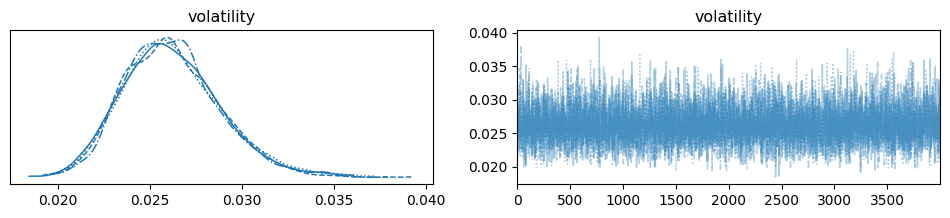

In [11]:
with pm.Model() as portfolio_model:
    pm.traceplot(trace, divergences=True)

In [12]:
pred_df = pd.DataFrame(future_returns)
pred_df.columns = sp_list

dti = pd.date_range(max(return_df.index) + pd.DateOffset(1), periods=10, freq="D")
pred_df = pred_df.set_index(dti)
print('pred \n', pred_df[:2])

pred_df = pd.concat([return_df[-1:], pred_df], axis=0)
t_df = return_df[-30:]
#t_df = return_df[-10:]
print('t_df: ',t_df.shape)

pred 
                ARKK
2023-11-18 0.003420
2023-11-19 0.010979
t_df:  (30, 1)


<br>

# Conclusion

The average 10-day out of sample predicted volatility for ARKK is 0.02618. The graph below outlines the historic volatitly for SPY and ARKK. It also depicts the 10 day volatitlty forcast for  ARKK

[*********************100%%**********************]  1 of 1 completed
stock_df (50, 1)


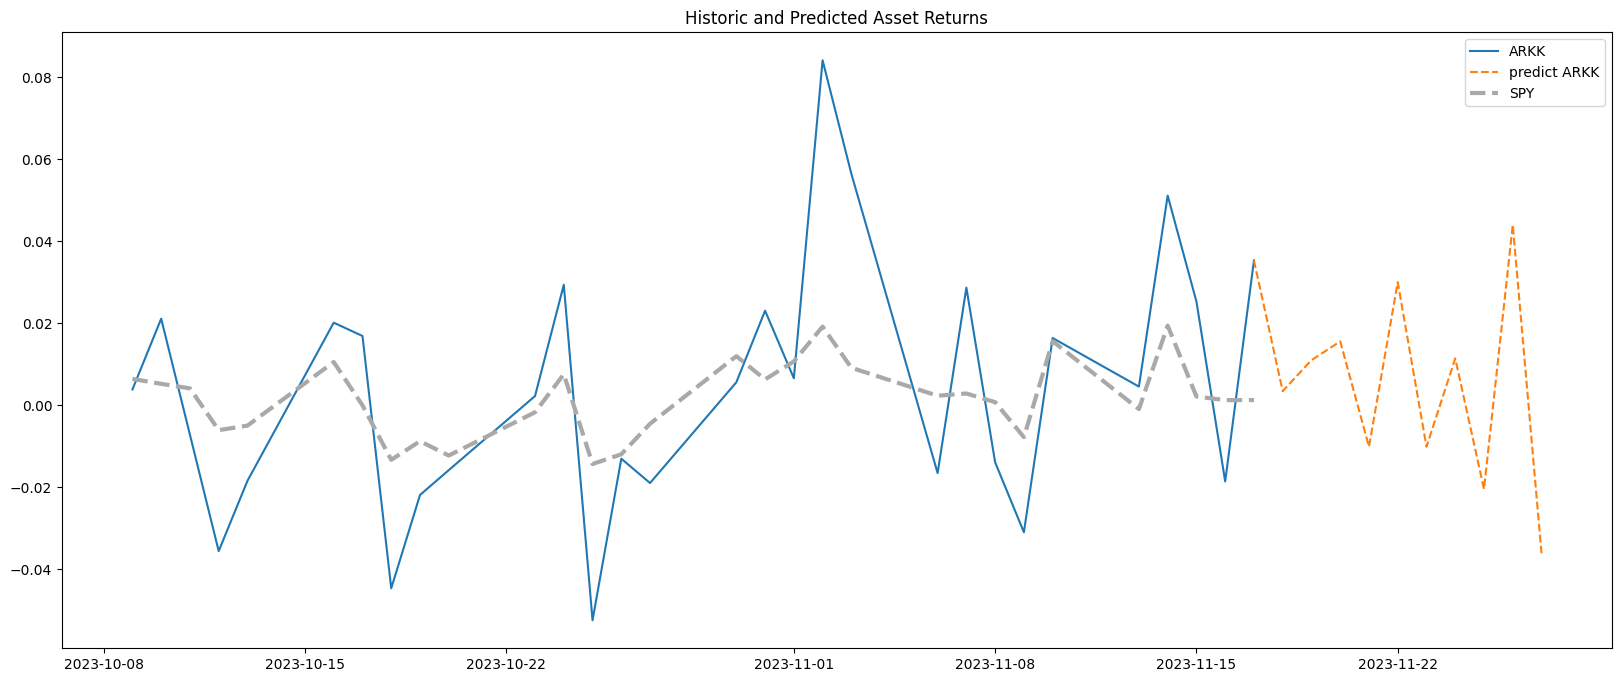

In [13]:
# load index data and calculate returns
idx_df = pdr.get_data_yahoo('SPY', start=purchase_date, end=today)[['Close']]
print('stock_df',idx_df.shape)
idx_df = idx_df[['Close']].pct_change().dropna()
idx_df = idx_df[-30:]


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

for ticker in set(sp_list):
    plt.plot(t_df.index, t_df[ticker], label=f'{ticker}')
    
for ticker in set(sp_list):
    plt.plot(pred_df.index, pred_df[ticker], label=f'predict {ticker}', linestyle='--')
    
plt.plot(idx_df.index, idx_df['Close'], color='darkgray', linestyle='--', label='SPY', linewidth=3)

#plt.axvline(x=max(return_df.index), color='darkgray', linestyle='--', label='history', linewidth=3)


ax.set(title='Historic and Predicted Asset Returns');
plt.legend()
plt.grid(False)
plt.show()